In [1]:
# Imports
import pretty_midi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import reverse_pianoroll
import IPython.display as ipd
np.set_printoptions(threshold=np.nan)

In [2]:
tempo = 120.0  # beats per min
input_length = 3.0  # seconds
sr = 22050  # sample rate for synthesis
hop_length = 512
note_velocity = 90
min_pitch = 60  # C4
max_pitch = 69  # A4
num_notes = int(input_length / 60.0 * tempo)
secs_per_beat = 60.0 / tempo

In [3]:
# generate midi
piano_midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
piano_instr = pretty_midi.Instrument(1)

# play one note per beat
for i in range(num_notes):
    note_start = i * secs_per_beat
    note_end = (i+1) * secs_per_beat
    note_pitch = np.random.randint(min_pitch, max_pitch+1)
    note = pretty_midi.Note(note_velocity, note_pitch, note_start, note_end)
    piano_instr.notes.append(note)
piano_midi.instruments.append(piano_instr)

In [4]:
# generate audio
piano_audio = piano_midi.fluidsynth(fs=sr)[:int(sr*input_length)]
print(len(piano_audio))
ipd.Audio(piano_audio, rate=sr)

66150


C shape: (84, 258)


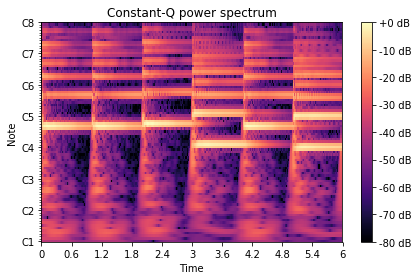

In [5]:
# get spectrogram from audio (training input)
C = np.abs(librosa.cqt(piano_audio, sr=sr, hop_length=hop_length, n_bins=84))
C = C[:, :-1]  # fix off by 1 error
print("C shape: {}".format(C.shape))
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [6]:
# get training labels

# 22050 samples/sec / 512 samples/hop = 43.06640625 hops/sec
# units of fs: hops/sec
fs = sr / hop_length  # sampling frequency of columns; time between column samples is 1./fs seconds
piano_roll = piano_midi.get_piano_roll(fs=fs)
print(piano_roll.shape)

C1 = 4
C8 = 88
# reduce range of piano roll to match spectrogram
piano_roll = np.transpose(piano_roll[C1:C8, :])
# convert note velocity to binary note ON or OFF
piano_roll = (piano_roll != 0).astype(int)
print(piano_roll.shape)
print(piano_roll)

(128, 258)
(258, 84)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 

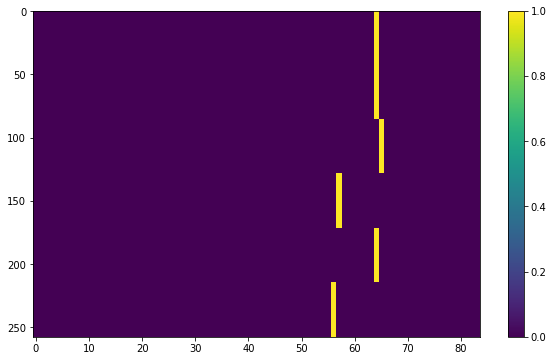

In [12]:
plt.figure(figsize=(10,6))
plt.imshow(piano_roll, aspect='auto')
plt.colorbar()